In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import os, time

In [2]:
%%bash
ls /app/data
pwd

models
processed
raw
/app/notebooks


In [3]:
dir_raw_data = '/app/data/raw'
dir_processed_data = '/app/data/processed'
dir_model = '/app/data/models/'

In [4]:
os.listdir(dir_raw_data)

['Nutrition__Physical_Activity__and_Obesity.csv']

## Study case
### Introduction

### Goal
I would like to make a model that can predict the value of each question, and model the join probability distribution of each question (bayesian network)

In [5]:
raw_file_path = os.path.join(dir_raw_data, 'Nutrition__Physical_Activity__and_Obesity.csv')
df_raw = pd.read_csv(raw_file_path)
display(df_raw.sample(5).T)

,9765,65594,13449,81072,13823
YearStart,2020,2011,2017,2021,2017
YearEnd,2020,2011,2017,2021,2017
LocationAbbr,WY,SD,WI,MA,ND
LocationDesc,Wyoming,South Dakota,Wisconsin,Massachusetts,North Dakota
Datasource,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System
Class,Physical Activity,Physical Activity,Obesity / Weight Status,Fruits and Vegetables,Physical Activity
Topic,Physical Activity - Behavior,Physical Activity - Behavior,Obesity / Weight Status,Fruits and Vegetables - Behavior,Physical Activity - Behavior
Question,Percent of adults who engage in no leisure-tim...,Percent of adults who engage in muscle-strengt...,Percent of adults aged 18 years and older who ...,Percent of adults who report consuming vegetab...,Percent of adults who engage in muscle-strengt...
Data_Value_Unit,NaN,NaN,NaN,NaN,NaN
Data_Value_Type,Value,Value,Value,Value,Value


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88629 entries, 0 to 88628
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   88629 non-null  int64  
 1   YearEnd                     88629 non-null  int64  
 2   LocationAbbr                88629 non-null  object 
 3   LocationDesc                88629 non-null  object 
 4   Datasource                  88629 non-null  object 
 5   Class                       88629 non-null  object 
 6   Topic                       88629 non-null  object 
 7   Question                    88629 non-null  object 
 8   Data_Value_Unit             0 non-null      float64
 9   Data_Value_Type             88629 non-null  object 
 10  Data_Value                  79851 non-null  float64
 11  Data_Value_Alt              79851 non-null  float64
 12  Data_Value_Footnote_Symbol  8778 non-null   object 
 13  Data_Value_Footnote         877

### EDA
#### Check the percentage of null values of all columns

In [7]:
n_row_raw, n_col_raw = df_raw.shape
na_values = pd.DataFrame(
    [[col, df_raw[col].isna().sum()] for col in df_raw.columns],
    columns = ['columns', 'total of null values']
)
na_values['% null values'] = na_values['total of null values'].apply(lambda x: x/n_row_raw*100)
na_values

,columns,total of null values,% null values
0,YearStart,0,0.000000
1,YearEnd,0,0.000000
2,LocationAbbr,0,0.000000
3,LocationDesc,0,0.000000
4,Datasource,0,0.000000
5,Class,0,0.000000
6,Topic,0,0.000000
7,Question,0,0.000000
8,Data_Value_Unit,88629,100.000000
9,Data_Value_Type,0,0.000000


From the table we could see that many collumns has NaN values. For now we drop the column with 100% NaN values, and row with NaN values for their StratificationID1 and Data Values

In [8]:
df = df_raw.drop('Data_Value_Unit', axis=1)
df.dropna(subset=['StratificationID1', 'Data_Value'],inplace=True)
n_row = df.shape[0]
print(n_row)

79851


Percentage that yearstart is equal to yearend is 110.99%


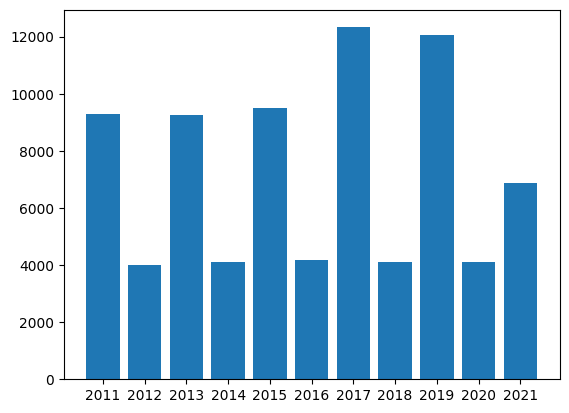

In [9]:
print("Percentage that yearstart is equal to yearend is %.2f%%"%(np.sum(df_raw.YearEnd==df_raw.YearStart)/n_row*100))
year_counts = df.YearStart.value_counts()
years = year_counts.index
counts = year_counts.values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(years, counts)
ax.set_xticks(years)
ax.set_xticklabels(years)
plt.show()

In [10]:
groups = ['YearStart', 'QuestionID']
df['count'] = 1
df_group_count = df[groups+['count', 'LocationID', 'Sample_Size']].groupby(groups).agg({'count': 'count', 'Sample_Size': 'sum',
                                                                                        'LocationID': lambda x: np.unique(x).size})
df_group_count

count  Sample_Size  LocationID
YearStart QuestionID                                
2011      Q036         1332    5633938.0          52
          Q037         1332    5625879.0          52
          Q043         1328    5483418.0          52
          Q044         1326    5431254.0          52
          Q045         1325    5445086.0          52
          Q046         1332    5616671.0          52
          Q047         1332    5685372.0          52
2012      Q036         1332    5286793.0          52
          Q037         1332    5286793.0          52
          Q047         1336    5561683.0          52
2013      Q036         1344    5505352.0          53
          Q037         1344    5505352.0          53
          Q043         1312    5179117.0          52
          Q044         1312    5130195.0          52
          Q045         1312    5137667.0          52
          Q046         1315    5312132.0          52
          Q047         1318    5380911.0          52
2014      Q036         1369    5141848.0          54
          Q037         1369    5141848.0          54
          Q047         1376    5478803.0          54
2015      Q036         1361    4804303.0          54
          Q037         1361    4804303.0          54
          Q043         1354    4602722.0          54
          Q044         1353    4552212.0          54
          Q045         1354    4571320.0          54
          Q046         1356    4711354.0          54
          Q047         1358    4782902.0          54
2016      Q036         1389    5292884.0          55
          Q037         1389    5292884.0          55
          Q047         1399    5750829.0          55
2017      Q018         1370    4874887.0          54
          Q019         1369    4776230.0          54
          Q036         1372    4917174.0          54
          Q037         1372    4917174.0          54
          Q043         1369    4753527.0          54
          Q044         1368    4692451.0          54
          Q045         1368    4723369.0          54
          Q046         1369    4855357.0          54
          Q047         1372    4941498.0          54
2018      Q036         1369    4770419.0          54
          Q037         1369    4770419.0          54
          Q047         1377    5176936.0          54
2019      Q018         1338    4409307.0          53
          Q019         1334    4301478.0          53
          Q036         1343    4518816.0          53
          Q037         1343    4518816.0          53
          Q043         1337    4347037.0          53
          Q044         1333    4283368.0          53
          Q045         1337    4364273.0          53
          Q046         1340    4505397.0          53
          Q047         1346    4684532.0          53
2020      Q036         1368    4269137.0          54
          Q037         1368    4269137.0          54
          Q047         1382    4748426.0          54
2021      Q018         1372    4563502.0          54
          Q019         1372    4444630.0          54
          Q036         1377    4642364.0          54
          Q037         1377    4642364.0          54
          Q047         1388    5182009.0          54

From the table and the graph we can see that in even years the amount of questions being asked is lesser than odd years. From the table we could see the question that being asked during the even years are exactly Q036, Q037, and Q047.

In [11]:
groups = ['QuestionID', 'Question']
dfq = df[groups].groupby(groups).count()
display(dfq)
dfq = dfq.reset_index()
qdict = dict([(dfq.loc[i, 'QuestionID'], dfq.loc[i, 'Question']) for i in range(dfq.shape[0])])

,
QuestionID,Question
Q018,Percent of adults who report consuming fruit less than one time daily
Q019,Percent of adults who report consuming vegetables less than one time daily
Q036,Percent of adults aged 18 years and older who have obesity
Q037,Percent of adults aged 18 years and older who have an overweight classification
Q043,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)
Q044,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week
Q045,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)
Q046,Percent of adults who engage in muscle-strengthening activities on 2 or more days a week
Q047,Percent of adults who engage in no leisure-time physical activity


In [12]:
groups = ['LocationAbbr', 'LocationID']
df[groups].groupby(groups).count()

,
LocationAbbr,LocationID
AK,2
AL,1
AR,5
AZ,4
CA,6
CO,8
CT,9
DC,11
DE,10


In [13]:
def get_item_from_df(df, **args):
    n_row = df.shape[0]
    cond = np.ones(n_row, dtype=bool)
    for key in args:
        if isinstance(args[key], list):
            temp = np.zeros(n_row, dtype=bool)
            for val in args[key]:
                temp = np.logical_or(df[key]==val, temp)
        else:
            temp = (df[key]==args[key])
        cond = np.logical_and(cond, temp)
    return df[cond]

get_item_from_df(df, QuestionID='Q036', YearStart=2011, LocationAbbr='NY').T

,21627,23756,25782,26289,27060,29155,31115,41030,47672,52437,...,66073,67445,69998,70250,70270,71548,73080,74182,74515,76008
YearStart,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
YearEnd,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
LocationAbbr,NY,NY,NY,NY,NY,NY,NY,NY,NY,NY,...,NY,NY,NY,NY,NY,NY,NY,NY,NY,NY
LocationDesc,New York,New York,New York,New York,New York,New York,New York,New York,New York,New York,...,New York,New York,New York,New York,New York,New York,New York,New York,New York,New York
Datasource,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,...,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System
Class,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,...,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status
Topic,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,...,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status
Question,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...
Data_Value_Type,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value,...,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value
Data_Value,32.5,26.5,27.5,27.1,28.5,26.0,24.5,18.2,26.9,26.3,...,36.1,30.5,22.1,23.6,9.5,25.3,29.8,20.1,23.7,25.9


In [14]:
# Let's see if there's multiple surveys with same question, same year, same location, and same stratification
groups = ['YearStart', 'QuestionID', 'LocationID', 'StratificationID1']
np.all(df[groups+['count']].groupby(groups).sum()==1) # If it false then there's exist such multiple survey.

np.True_

### EDA (focused)
Lets analyze the survey result for each year. From previous analysis we could see that the question that being asked for each year are exactly Q036, Q037, and Q047. So from now on, we focused on those questions and see what are the connections between those questions and their stratifications.

In [15]:
df = get_item_from_df(df, QuestionID=['Q036','Q037','Q047'])
df.sample(10).T

,21894,74352,53381,9341,77058,85418,48126,40152,72791,22633
YearStart,2015,2013,2013,2020,2016,2021,2015,2019,2014,2012
YearEnd,2015,2013,2013,2020,2016,2021,2015,2019,2014,2012
LocationAbbr,TN,ND,AK,AR,SC,WY,CO,CO,NE,IA
LocationDesc,Tennessee,North Dakota,Alaska,Arkansas,South Carolina,Wyoming,Colorado,Colorado,Nebraska,Iowa
Datasource,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System
Class,Physical Activity,Obesity / Weight Status,Physical Activity,Physical Activity,Obesity / Weight Status,Physical Activity,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Physical Activity
Topic,Physical Activity - Behavior,Obesity / Weight Status,Physical Activity - Behavior,Physical Activity - Behavior,Obesity / Weight Status,Physical Activity - Behavior,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Physical Activity - Behavior
Question,Percent of adults who engage in no leisure-tim...,Percent of adults aged 18 years and older who ...,Percent of adults who engage in no leisure-tim...,Percent of adults who engage in no leisure-tim...,Percent of adults aged 18 years and older who ...,Percent of adults who engage in no leisure-tim...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults who engage in no leisure-tim...
Data_Value_Type,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value
Data_Value,33.5,30.0,14.4,37.0,33.4,19.7,39.1,36.6,28.3,31.6


In [16]:
df[['QuestionID','Question']].groupby(['QuestionID','Question']).count()

,
QuestionID,Question
Q036,Percent of adults aged 18 years and older who have obesity
Q037,Percent of adults aged 18 years and older who have an overweight classification
Q047,Percent of adults who engage in no leisure-time physical activity


In [17]:
# Count the number of location and stratification for each survey
# because for each survey in each location, and stratification only can be done once,
# then the number of same location in the grouped df corresponds to the number of stratification.
groups = ['YearStart','QuestionID']
df_grouped = df[groups+['LocationID','count']].groupby(groups).apply(
    lambda x: pd.Series({
        'number of location': np.unique(x['LocationID']).size,
        'min_number_stratification_each_location': x['LocationID'].value_counts().min(), 
        'max_number_stratification_each_location': x['LocationID'].value_counts().max(), 
    })
)

df_grouped

/tmp/ipykernel_25/2733926866.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df[groups+['LocationID','count']].groupby(groups).apply(


number of location  \
YearStart QuestionID                       
2011      Q036                        52   
          Q037                        52   
          Q047                        52   
2012      Q036                        52   
          Q037                        52   
          Q047                        52   
2013      Q036                        53   
          Q037                        53   
          Q047                        52   
2014      Q036                        54   
          Q037                        54   
          Q047                        54   
2015      Q036                        54   
          Q037                        54   
          Q047                        54   
2016      Q036                        55   
          Q037                        55   
          Q047                        55   
2017      Q036                        54   
          Q037                        54   
          Q047                        54   
2018      Q036                        54   
          Q037                        54   
          Q047                        54   
2019      Q036                        53   
          Q037                        53   
          Q047                        53   
2020      Q036                        54   
          Q037                        54   
          Q047                        54   
2021      Q036                        54   
          Q037                        54   
          Q047                        54   

                      min_number_stratification_each_location  \
YearStart QuestionID                                            
2011      Q036                                             23   
          Q037                                             23   
          Q047                                             23   
2012      Q036                                             23   
          Q037                                             23   
          Q047                                             23   
2013      Q036                                             21   
          Q037                                             21   
          Q047                                             22   
2014      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2015      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2016      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2017      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2018      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2019      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2020      Q036                                             21   
          Q037                                             21   
          Q047                                             21   
2021      Q036                                             21   
          Q037                                             21   
          Q047                                             21   

                      max_number_stratification_each_location  
YearStart QuestionID                                           
2011      Q036                                             28  
          Q03

Lets see which stratifications that is conducted throughout all surveys

In [18]:
all_stratifications = set(np.unique(df['StratificationID1']))
df_grouped = df[['YearStart','QuestionID','LocationID','StratificationID1']].groupby(['YearStart','QuestionID','LocationID']).agg(
    all_stratifications = ('StratificationID1', lambda x: set(x)),
)
result = all_stratifications
for s in df_grouped['all_stratifications']:
    result = result & s
print(f"There are  {len(result)} stratifications that are conducted for each surveys in each areas, that is {', '.join(result)}.")
missing_stratifications = all_stratifications-result
print(f"Stratifications that are not always conducted are {', '.join(missing_stratifications)}.")

There are  19 stratifications that are conducted for each surveys in each areas, that is EDUHSGRAD, FEMALE, INCLESS15, AGEYR4554, INC75PLUS, INC3550, EDUHS, OVERALL, INCNR, INC2535, INC1525, EDUCOGRAD, AGEYR1824, AGEYR2534, AGEYR5564, EDUCOTEC, MALE, AGEYR3544, AGEYR65PLUS.
Stratifications that are not always conducted are RACEASN, RACENAA, RACE2PLUS, RACEHIS, INC5075, RACEOTH, RACEWHT, RACEBLK, RACEHPI.


To analyze the measurement of each stratification, we need to do somethin to the location maybe by combining two or more location so that all stratifications can be covered. but now lets see which one that has missing stratifications.

In [19]:
df_grouped['missing_stratifications'] = df_grouped['all_stratifications'].apply(lambda x: missing_stratifications-x)
df_grouped['n_missing'] = df_grouped['missing_stratifications'].apply(lambda x: len(x))

In [20]:
df_grouped[df_grouped['n_missing']>0]

all_stratifications  \
YearStart QuestionID LocationID                                                      
2011      Q036       1           {RACENAA, EDUHSGRAD, FEMALE, RACE2PLUS, INCLES...   
                     2           {RACENAA, EDUHSGRAD, FEMALE, RACEOTH, RACE2PLU...   
                     4           {RACENAA, FEMALE, EDUHSGRAD, INCLESS15, RACE2P...   
                     5           {RACENAA, FEMALE, EDUHSGRAD, RACE2PLUS, INCLES...   
                     6           {RACENAA, FEMALE, EDUHSGRAD, RACEHPI, RACE2PLU...   
...                                                                            ...   
2021      Q047       55          {RACENAA, EDUHSGRAD, FEMALE, RACE2PLUS, INCLES...   
                     56          {RACENAA, FEMALE, EDUHSGRAD, RACE2PLUS, INCLES...   
                     66          {FEMALE, EDUHSGRAD, RACEHPI, RACE2PLUS, INCLES...   
                     72          {EDUHSGRAD, FEMALE, INCLESS15, AGEYR4554, INC7...   
                     78          {EDUHSGRAD, FEMALE, INCLESS15, AGEYR4554, INC7...   

                                                           missing_stratifications  \
YearStart QuestionID LocationID                                                      
2011      Q036       1                                 {RACEOTH, RACEHPI, RACEASN}   
                     2                                 {RACEHPI, RACEBLK, RACEASN}   
                     4                                          {RACEOTH, RACEHPI}   
                     5                                 {RACEOTH, RACEHPI, RACEASN}   
                     6                                                   {RACEOTH}   
...                                                                            ...   
2021      Q047       55                                         {RACEOTH, RACEHPI}   
                     56                       {RACEOTH, RACEHPI, RACEBLK, RACEASN}   
                     66                                {RACEOTH, RACENAA, RACEBLK}   
                     72          {RACEHPI, RACEASN, RACENAA, RACEOTH, RACEWHT, ...   
                     78            {RACEASN, RACENAA, RACE2PLUS, RACEOTH, RACEHPI}   

                                 n_missing  
YearStart QuestionID LocationID             
2011      Q036       1                   3  
                     2                   3  
                     4                   2  
                     5                   3  
                     6                   1  
...                                    ...  
2021      Q047       55                  2  
                     56                  4  
                     66                  3  
                     72                  7  
                     78                  5  

[1711 rows x 3 columns]

#### For simplicity i will analyze by combining all location into a national level

In [21]:
groups = ['StratificationCategory1', 'StratificationID1']
df[groups].groupby(groups).count()

Empty DataFrame
Columns: []
Index: [(Age (years), AGEYR1824), (Age (years), AGEYR2534), (Age (years), AGEYR3544), (Age (years), AGEYR4554), (Age (years), AGEYR5564), (Age (years), AGEYR65PLUS), (Education, EDUCOGRAD), (Education, EDUCOTEC), (Education, EDUHS), (Education, EDUHSGRAD), (Gender, FEMALE), (Gender, MALE), (Income, INC1525), (Income, INC2535), (Income, INC3550), (Income, INC5075), (Income, INC75PLUS), (Income, INCLESS15), (Income, INCNR), (Race/Ethnicity, RACE2PLUS), (Race/Ethnicity, RACEASN), (Race/Ethnicity, RACEBLK), (Race/Ethnicity, RACEHIS), (Race/Ethnicity, RACEHPI), (Race/Ethnicity, RACENAA), (Race/Ethnicity, RACEOTH), (Race/Ethnicity, RACEWHT), (Total, OVERALL)]

In [22]:
df[df['StratificationCategory1']=='Total'].sample(10).T

,78591,33452,77858,2187,7885,27102,32963,66779,65659,5006
YearStart,2016,2017,2016,2018,2016,2015,2014,2015,2015,2018
YearEnd,2016,2017,2016,2018,2016,2015,2014,2015,2015,2018
LocationAbbr,LA,OR,CA,AK,OH,NM,NH,AZ,NJ,MN
LocationDesc,Louisiana,Oregon,California,Alaska,Ohio,New Mexico,New Hampshire,Arizona,New Jersey,Minnesota
Datasource,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System,Behavioral Risk Factor Surveillance System
Class,Physical Activity,Obesity / Weight Status,Physical Activity,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Physical Activity,Obesity / Weight Status,Physical Activity,Physical Activity
Topic,Physical Activity - Behavior,Obesity / Weight Status,Physical Activity - Behavior,Obesity / Weight Status,Obesity / Weight Status,Obesity / Weight Status,Physical Activity - Behavior,Obesity / Weight Status,Physical Activity - Behavior,Physical Activity - Behavior
Question,Percent of adults who engage in no leisure-tim...,Percent of adults aged 18 years and older who ...,Percent of adults who engage in no leisure-tim...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults aged 18 years and older who ...,Percent of adults who engage in no leisure-tim...,Percent of adults aged 18 years and older who ...,Percent of adults who engage in no leisure-tim...,Percent of adults who engage in no leisure-tim...
Data_Value_Type,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value
Data_Value,29.1,35.1,20.5,34.7,31.5,35.7,19.3,28.4,27.2,20.5


Verify if Overall Measure can be interpreted as National Measure

In [23]:
from itertools import product
    
questions = ['Q036','Q037','Q047']
years = np.arange(2011,2022)
for y, q in product(years, questions):
    cond = np.logical_and(df['YearStart']==y, df['QuestionID']==q)
    df_test = df[cond]
    df_total = df_test[df_test['StratificationCategory1']=='Total']
    df_gender = df_test[df_test['StratificationCategory1']=='Gender']
    # Perform t-test for overall and the combined male and female survey
    print('The calculation of t-test for question %s in %s:'%(q,y))
    t_stat, p_value = ss.ttest_ind(df_total['Data_Value'],df_gender['Data_Value'])
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print('----------------------------')

The calculation of t-test for question Q036 in 2011:
T-statistic: 0.017508666049411807
P-value: 0.9860534827107983
----------------------------
The calculation of t-test for question Q037 in 2011:
T-statistic: 0.07252838870119786
P-value: 0.942275526452044
----------------------------
The calculation of t-test for question Q047 in 2011:
T-statistic: 0.05423128456824703
P-value: 0.9568211852644524
----------------------------
The calculation of t-test for question Q036 in 2012:
T-statistic: 0.017792356679508643
P-value: 0.9858275329197883
----------------------------
The calculation of t-test for question Q037 in 2012:
T-statistic: 0.05736842035870143
P-value: 0.9543260868312033
----------------------------
The calculation of t-test for question Q047 in 2012:
T-statistic: 0.07940997838712834
P-value: 0.9368096272298599
----------------------------
The calculation of t-test for question Q036 in 2013:
T-statistic: 0.014371805049332493
P-value: 0.988551600227106
---------------------------

Since all p-value is greater than 0.8 (greater than significance level alpha=0.05) then we can conclude that overall survey indeed can represent for all category.

In [24]:
def pooled_value(x):
    n = x['Sample_Size']
    weighted_sum = (n*x['Data_Value']).sum()
    return weighted_sum/n.sum()

groups = ['YearStart', 'QuestionID']
df_ovr = df[df['StratificationCategory1']=='Total'].groupby(groups).apply(
    lambda x: pd.Series({
        'Data_Value': pooled_value(x),
        'Sample_Size': x['Sample_Size'].sum()
    })
).reset_index()
df_ovr

/tmp/ipykernel_25/521831112.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ovr = df[df['StratificationCategory1']=='Total'].groupby(groups).apply(


,YearStart,QuestionID,Data_Value,Sample_Size
0,2011,Q036,27.417967,941400.0
1,2011,Q037,35.717139,941062.0
2,2011,Q047,25.433015,950156.0
3,2012,Q036,27.758852,884460.0
4,2012,Q037,35.698795,884460.0
5,2012,Q047,23.035985,931554.0
6,2013,Q036,28.308947,920736.0
7,2013,Q037,35.526369,920736.0
8,2013,Q047,26.114163,900186.0
9,2014,Q036,28.973102,859845.0


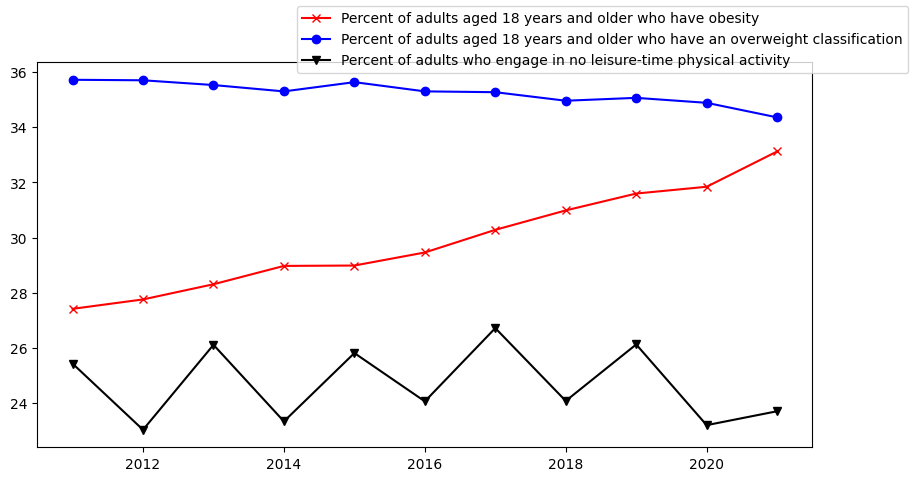

In [25]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
qids = ['Q036', 'Q037', 'Q047']
markers = ['r-x', 'b-o', 'k-v']
for i, qid in enumerate(qids):
    dfq = df_ovr[df_ovr['QuestionID']==qid]
    years = dfq['YearStart']
    percentages = dfq['Data_Value']
    ax.plot(years, percentages, markers[i], label=qdict[qid])
fig.legend()
plt.show()

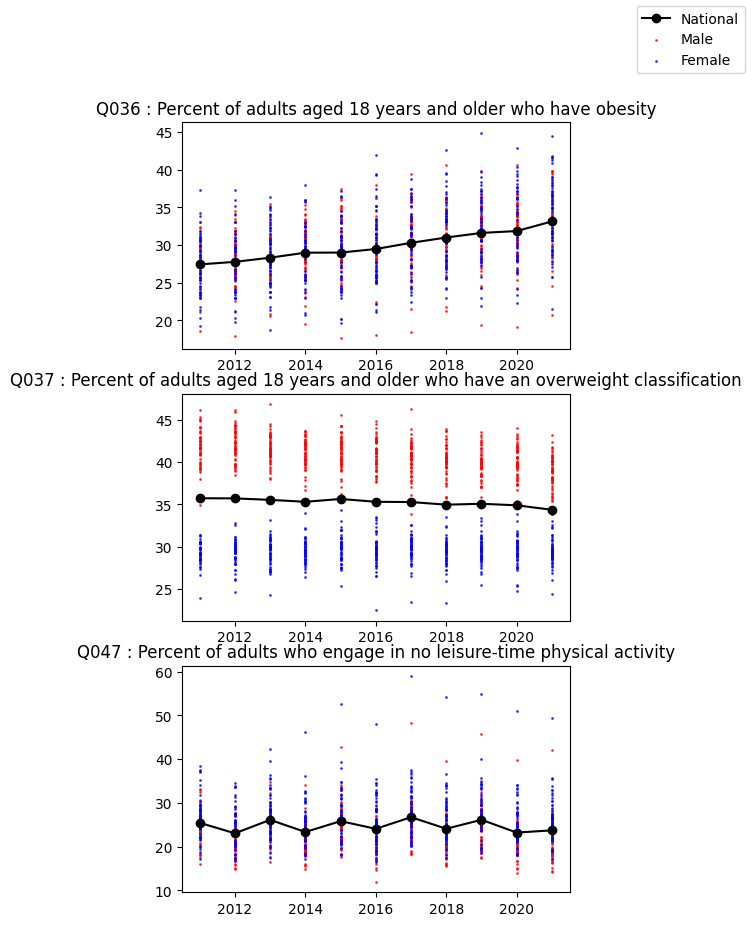

In [26]:
# Lets see how the survey goes to gender specific audience and compare those with the overall audience
df_male = df[df['StratificationID1']=='MALE']
df_female = df[df['StratificationID1']=='FEMALE']
qids = ['Q036', 'Q037', 'Q047']

fig = plt.figure(figsize=(5,10))
for i, qid in enumerate(qids):
    ax = fig.add_subplot(3,1,i+1)
    dfq = df_ovr[df_ovr['QuestionID']==qid]
    years = dfq['YearStart']
    percentages = dfq['Data_Value']
    ax.plot(years, percentages, 'k-o', label='National')
    years = df_male.loc[df_male['QuestionID']==qid, 'YearStart']
    percentages = df_male.loc[df_male['QuestionID']==qid, 'Data_Value']
    ax.scatter(years, percentages, color='red', s=1, alpha=.7, label='Male')
    years = df_female.loc[df_female['QuestionID']==qid, 'YearStart']
    percentages = df_female.loc[df_female['QuestionID']==qid, 'Data_Value']
    ax.scatter(years, percentages, color='blue', s=1, alpha=.7, label='Female')
    ax.set_title(f'{qid} : {qdict[qid]}')
    if i==0:
        fig.legend()  
plt.show()

In [27]:
# t-testing the result
def ttest_gender(year, qid):
    measurement_male = df_male.loc[np.logical_and(df_male['QuestionID']==qid, df_male['YearStart']==year), 'Data_Value']
    measurement_female = df_female.loc[np.logical_and(df_female['QuestionID']==qid, df_female['YearStart']==year), 'Data_Value']
    t_stat, p_value = ss.ttest_ind(measurement_male, measurement_female)
    return t_stat, p_value
    
df_ttest = pd.DataFrame(np.arange(2011,2022).reshape((-1,1)), columns=['YearStart'])
for qid in qids:
    df_ttest[f'{qid} (t_stat, p_value)'] = df_ttest['YearStart'].apply(lambda x: ttest_gender(x,qid))
df_ttest

,YearStart,"Q036 (t_stat, p_value)","Q037 (t_stat, p_value)","Q047 (t_stat, p_value)"
0,2011,"(1.2013262336500388, 0.23240673031422085)","(36.912300745342804, 7.945456931032174e-61)","(-2.47566774484846, 0.014945411745444448)"
1,2012,"(0.779998555154745, 0.4371979561760777)","(35.534667670541396, 2.9148391417458708e-59)","(-4.241178429199311, 4.899831942335353e-05)"
2,2013,"(0.6249583129641435, 0.5333672302901339)","(38.539170502162776, 2.1393230788098341e-63)","(-2.993206414902011, 0.003463324796444609)"
3,2014,"(0.44696758595524183, 0.6558103891838506)","(40.078224975975694, 7.308623752426686e-66)","(-4.6246106144442605, 1.0647700013361755e-05)"
4,2015,"(1.0905873453592914, 0.27792740045087416)","(33.847120521387545, 1.2081946243899876e-58)","(-2.3324278345042972, 0.02156735151148752)"
5,2016,"(-0.04433853566179646, 0.9647164304120155)","(29.68386373686438, 9.332664211091569e-54)","(-4.634505480374483, 1.0057666375212101e-05)"
6,2017,"(0.49028161869557574, 0.6249479427945324)","(31.0821763692971, 4.4579300493382544e-55)","(-2.476971027387383, 0.01483080834979179)"
7,2018,"(-0.5219584082746632, 0.602788309420454)","(30.916489023878995, 7.429624135128103e-55)","(-4.669341739909286, 8.894102506832588e-06)"
8,2019,"(-0.8904336392297519, 0.37528834380946186)","(31.449329072516186, 6.164526205397524e-55)","(-2.6719552772339963, 0.0087555143757037)"
9,2020,"(-0.6240819548631046, 0.5339145890544056)","(28.881922856741408, 4.732739181559996e-52)","(-4.468100289943701, 1.982379491491631e-05)"


By using significance level of 0.05, from the table above we could conclude that the average percentages of female adult who have overweight is more then the male percentages (t_stat positive), and the percentages of female adult who engage no leisure-time physical activity is less then the male percentages (t_stat negative).

In [39]:
def generate_colors(n, seed=0):
    rng = np.random.default_rng(seed)
    return rng.random((n, 3))
    
def analyze(category):
    
    stratifications = np.unique(df.loc[df['StratificationCategory1']==category, 'StratificationID1'])
    strat_dfs = dict([(strat, df[df['StratificationID1']==strat]) for strat in stratifications])
    
    fig = plt.figure(figsize=(5,10))
    qids = ['Q036', 'Q037', 'Q047']
    colors = generate_colors(len(stratifications))
    
    for i, qid in enumerate(qids):
        ax = fig.add_subplot(3,1,i+1)
        dfq = df_ovr[df_ovr['QuestionID']==qid]
        years = dfq['YearStart']
        percentages = dfq['Data_Value']
        ax.plot(years, percentages, 'k-o', label='Overall')
        for j, strat in enumerate(stratifications):
            years = strat_dfs[strat].loc[strat_dfs[strat]['QuestionID']==qid, 'YearStart']
            percentages = strat_dfs[strat].loc[strat_dfs[strat]['QuestionID']==qid, 'Data_Value']
            ax.scatter(years, percentages, color=colors[j], s=2, alpha=.7, label=strat)
        ax.set_title(f'{qid} : {qdict[qid]}')
        if i==0:
            fig.legend()  
    plt.show()

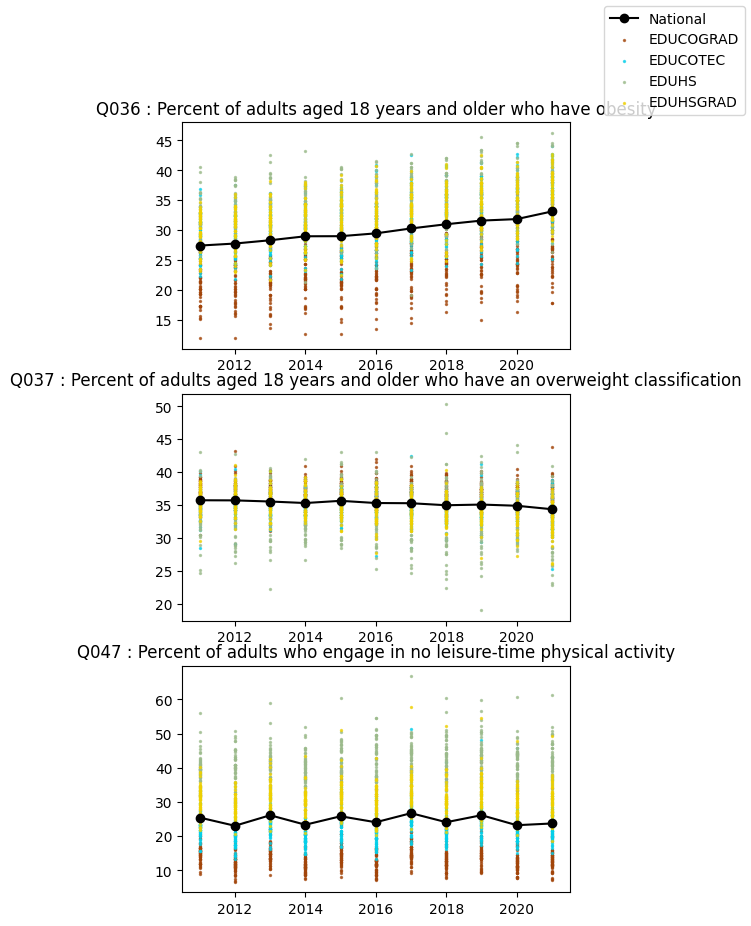

In [40]:
analyze('Education')

array([[0.63696169, 0.26978671],
       [0.04097352, 0.01652764],
       [0.81327024, 0.91275558]])